# Logistic Regression with Mini-Batch Gradient Descent using TensorFlow

First, let's create the moons dataset using Scikit-Learn's make_moons() function:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplolib as mpl
import os
from sklearn.datasets import make_moons
from sklearn.metrics import precision_score, recall_score
from datetime import datetime


def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
mpl.style.use('ggplot')

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

Let's take a peek at the dataset:

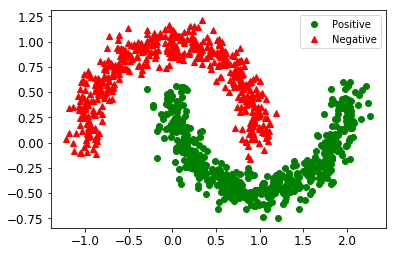

In [2]:
plt.plot(X_moons[y_moons==1, 0], X_moons[y_moons==1, 1], 'go', label='Positive')
plt.plot(X_moons[y_moons==0, 0], X_moons[y_moons==0, 1], 'r^', label='Negative')
plt.legend()
plt.show()

In [3]:
X_moons_bias = np.c_[np.ones((m, 1)), X_moons]
y_moons_column_vector = y_moons.reshape(-1, 1)

X_moons_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

Now let's split the data into a training set and a test set:

In [4]:
test_ratio = 0.2
test_size = int(test_ratio * m)
X_train = X_moons_bias[:-test_size]
X_test = X_moons_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

Create a random batch function:

In [5]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

As we saw in chapter 4, the log loss is a good cost function to use for Logistic Regression:

$J(\mathbf{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}$

Create the graph:

In [7]:
reset_graph()

learning_rate = 0.01
n_inputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs+1), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')
theta = tf.Variable(tf.random_uniform([n_inputs+1, 1], -1.0, 1.0, seed=42), name='theta')
logits = tf.matmul(X, theta, name='logits')
# y_proba = 1 / (1 + tf.exp(-logits))
y_proba = tf.sigmoid(logits)

# epsilon = 1e-7  # to avoid an overflow when computing the log
# loss = - tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))
loss = tf.losses.log_loss(y, y_proba)    # uses epsilon = 1e-7 by default
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

Just run the sess with mini-batch GD:

In [8]:
n_epoch = 1000
batch_size = 50
n_batch = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epoch):
        for batch_index in range(n_batch):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        if epoch % 100 == 0:
            loss_val = loss.eval(feed_dict={X: X_test, y: y_test})
            print("Epoch:", epoch, "\tLoss:", loss_val)
        
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.792602
Epoch: 100 	Loss: 0.343463
Epoch: 200 	Loss: 0.30754
Epoch: 300 	Loss: 0.292889
Epoch: 400 	Loss: 0.285336
Epoch: 500 	Loss: 0.280478
Epoch: 600 	Loss: 0.278083
Epoch: 700 	Loss: 0.276154
Epoch: 800 	Loss: 0.27552
Epoch: 900 	Loss: 0.274912


In [9]:
y_proba_val[:5]

array([[ 0.54895616],
       [ 0.70724374],
       [ 0.51900256],
       [ 0.9911136 ],
       [ 0.50859052]], dtype=float32)

Let's compute the model's precision and recall:

In [11]:
y_pred = (y_proba_val >= 0.5)

print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

precision: 0.862745098039
recall: 0.888888888889


Let's plot these predictions to see what they look like:

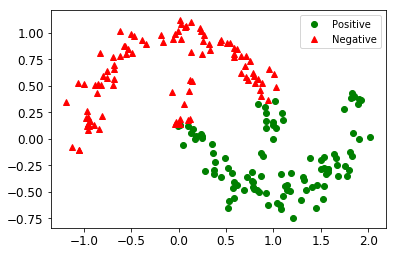

In [14]:
y_pred_idx = y_pred.reshape(-1)    # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label='Positive')
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label='Negative')
plt.legend()
plt.show()

Well, that looks pretty bad, doesn't it? But let's not forget that the Logistic Regression model has a linear decision boundary, so this is actually close to the best we can do with this model (unless we add more features, as we will show in a second).

Now let's start over, but this time we will add all the bells and whistles, as listed in the exercise:

* Define the graph within a logistic_regression() function that can be reused easily.
* Save checkpoints using a Saver at regular intervals during training, and save the final model at the end of training.
* Restore the last checkpoint upon startup if training was interrupted.
* Define the graph using nice scopes so the graph looks good in TensorBoard.
* Add summaries to visualize the learning curves in TensorBoard.
* Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

Before we start, we will add 4 more features to the inputs: ${x_1}^2$, ${x_2}^2$, ${x_1}^3$ and ${x_2}^3$. This was not part of the exercise, but it will demonstrate how adding features can improve the model. We will do this manually, but you could also add them using `
sklearn.preprocessing.PolynomialFeatures`.

In [15]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]

X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

Ok, next let's reset the default graph and define the `logistic_regression()` function to create the graph. We will leave out the definition of the inputs X and the targets  y. We could include them here, but leaving them out will make it easier to use this function in a wide range of use cases (e.g. perhaps we will want to add some preprocessing steps for the inputs before we feed them to the Logistic Regression model).

In [16]:
reset_graph()


def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope('logistic_regression'):
        with tf.name_scope('model'):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name='theta')
            logits = tf.matmul(X, theta, name='logits')
            y_proba = tf.sigmoid(logits)
        with tf.name_scope('train'):
            loss = tf.losses.log_loss(y, y_proba)
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope('init'):
            init = tf.global_variables_initializer()
        with tf.name_scope('saver'):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

Let's create a little function to get the name of the log directory to save the summaries for Tensorboard:

In [18]:
def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{0}/{1}/".format(root_logdir, name)

Next, let's create the graph, using the logistic_regression() function. We will also create the FileWriter to save the summaries to the log directory for Tensorboard:

In [19]:
n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

At last we can train the model! We will start by checking whether a previous training session was interrupted, and if so we will load the checkpoint and continue training from the epoch number we saved. In this example we just save the epoch number to a separate file, but in chapter 11 we will see how to store the training step directly as part of the model, using a non-trainable variable called `global_step` that we pass to the optimizer's `minimize()` method.

You can try interrupting training to verify that it does indeed restore the last checkpoint when you start it again.

In [22]:
n_epoch = 10001
batch_size = 50
n_batch = int(np.ceil(m / batch_size))

checkpoint_path = './tmp/my_logreg_model.ckpt'
checkpoint_epoch_path = checkpoint_path + '.epoch'
final_model_path = './my_logreg_model'

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
    
    for epoch in range(start_epoch, n_epoch):
        for batch_index in range(n_batch):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
    
    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Training was interrupted. Continuing at epoch 1001
INFO:tensorflow:Restoring parameters from ./tmp/my_logreg_model.ckpt
Epoch: 1500 	Loss: 0.0973275
Epoch: 2000 	Loss: 0.0836876
Epoch: 2500 	Loss: 0.0743772
Epoch: 3000 	Loss: 0.0674938
Epoch: 3500 	Loss: 0.0622093
Epoch: 4000 	Loss: 0.0580237
Epoch: 4500 	Loss: 0.0545616
Epoch: 5000 	Loss: 0.0517067
Epoch: 5500 	Loss: 0.0492363
Epoch: 6000 	Loss: 0.0471679
Epoch: 6500 	Loss: 0.0453748
Epoch: 7000 	Loss: 0.0438143
Epoch: 7500 	Loss: 0.0423769
Epoch: 8000 	Loss: 0.0410902
Epoch: 8500 	Loss: 0.039972
Epoch: 9000 	Loss: 0.038923
Epoch: 9500 	Loss: 0.038005
Epoch: 10000 	Loss: 0.0371535


Once again, we can make predictions by just classifying as positive all the instances whose estimated probability is greater or equal to 0.5:

In [23]:
y_pred = (y_proba_val >= 0.5)

print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

precision: 0.979797979798
recall: 0.979797979798


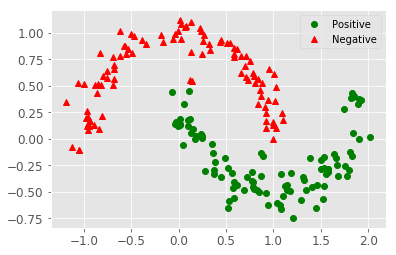

In [25]:
y_pred_idx = y_pred.reshape(-1)    # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label='Positive')
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label='Negative')
plt.legend()
plt.show()

Now that's much, much better! Apparently the new features really helped a lot.

Try starting the tensorboard server, find the latest run and look at the learning curve (i.e., how the loss evaluated on the test set evolves as a function of the epoch number):
```
> tensorboard --logdir=tf_logs
```